In [1]:
!pip install -Uqq fastbook kaggle waterfallcharts treeinterpreter dtreeviz
import fastbook
fastbook.setup_book()

In [2]:
import math

In [3]:
!apt install unzip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Suggested packages:
  zip
The following NEW packages will be installed:
  unzip
0 upgraded, 1 newly installed, 0 to remove and 1 not upgraded.
Need to get 168 kB of archives.
After this operation, 567 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 unzip amd64 6.0-21ubuntu1.1 [168 kB]
Fetched 168 kB in 0s (416 kB/s)
debconf: delaying package configuration, since apt-utils is not installed

78Selecting previously unselected package unzip.
(Reading database ... 15734 files and directories currently installed.)
Preparing to unpack .../unzip_6.0-21ubuntu1.1_amd64.deb ...
7Progress: [  0%] [..........................................................] 87Progress: [ 17%] [#########.................................................] 8Unpacking unzip (6.0-21ubuntu1.1) ...
7Progress: [ 33%] [###################............................

In [3]:
from fastbook import *

In [4]:
cred_path = Path('~/.kaggle/kaggle.json').expanduser()
cred_path

Path('/root/.kaggle/kaggle.json')

In [5]:
import os

if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    os.system("cp -n kaggle.json ~/.kaggle")
    cred_path.chmod(0o600)

In [21]:
#hide
from kaggle import api
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 20

In [7]:
from fastai.tabular.all import *

In [8]:
data_path = Path('/storage/data/titanic')
data_path.exists()

True

In [10]:
if not data_path.exists():
    os.system("mkdir /storage/data/titanic")

In [11]:
csv_names = ('train.csv', 'test.csv', 'gender_submission.csv')
for csv in csv_names:
    path = data_path/csv
    if not path.exists():
        os.system('kaggle competitions download -c titanic')
        os.system('mv titanic.zip /storage/data/titanic')
        os.system('unzip /storage/data/titanic/titanic.zip')
        os.system('rm /storage/data/titanic/titanic.zip')
        
for csv in csv_names:
    assert (data_path/csv).exists()

In [9]:
def r_mse(pred, y): return round(math.sqrt(((pred-y)**2).mean()), 6)

In [10]:
def error(pred, y):
    return torch.where(pred != y)[0].size()[0] / pred.size()[0]

In [11]:
def categorize_df(df : pd.DataFrame):
    df['Pclass'] = df['Pclass'].astype(pd.CategoricalDtype(categories=[1,2,3], ordered=True))
    return df

In [12]:
def create_dl(df, cat_names, cont_names, splits, procs):
    with no_random():
        dl = TabularPandas(
            df,
            procs,
            cat_names=cat_names,
            cont_names=cont_names,
            y_names="Survived",
            splits=splits,
            reduce_memory=False)
    return dl

In [13]:
def fit_and_calc_error(dl):
    with no_random():
        rf.fit(dl.train.xs, dl.train.y)
        
    predicted_train_ys = tensor(rf.predict(dl.train.xs))
    train_error = error(predicted_train_ys, tensor(dl.train.ys).squeeze() )
    # train_rmse = r_mse(predicted_train_ys, dl.train.ys)
    predicted_valid_ys = tensor(rf.predict(dl.valid.xs))
    valid_error = error(predicted_valid_ys, tensor(dl.valid.ys).squeeze() )
    # valid_rmse = r_mse(predicted_valid_ys, dl.valid.ys)
    return (rf, train_error, valid_error)

In [14]:
def feat_imp(model, x_names):
    return pd.DataFrame({'names' : x_names, 'imp' : model.feature_importances_ }).sort_values('imp', ascending=False)

In [15]:
def fit_calc_error_and_plot(dl):
    rf, train_error,valid_error = fit_and_calc_error(dl)
    feat_imp(rf, dl.train.xs.columns).plot(x='names',kind='barh')
    return train_error,valid_error

In [19]:
df = pd.read_csv(data_path/'train.csv', low_memory=False)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### Data checks (TODO Evaluate whether to do this or not. skipping for now)

#### Null values

Age and Cabin have the main null values. Embarked has a couple of nulls.
Check suitable fill values for nulls? There are columns to specify if age, cabin and embarked have null values. Ex. `Age_na`. Then when we check feature importance, it will tell us how important it is that the column is null.

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


(0.24544179523141654, 0.21910112359550563)

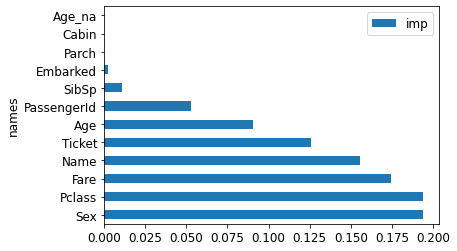

In [26]:
with no_random():
    df = categorize_df(df)
    cont_names,cat_names = cont_cat_split(df, dep_var='Survived')
    train,valid = RandomSplitter(seed=42)(df)
    rf = RandomForestClassifier(n_jobs=-1, min_samples_leaf=30, max_samples=100, max_features=3, oob_score=True, random_state=42)
procs = [Categorify, FillMissing]

dl = create_dl(df, cat_names=cat_names, cont_names=cont_names, splits=(train,valid), procs=procs)
fit_calc_error_and_plot(dl)

# (0.24544179523141654, 0.21910112359550563)

In [27]:
rf.oob_score_, rf.score(dl.valid.xs, dl.valid.ys)

(0.7475455820476858, 0.7808988764044944)

In [49]:
cont_names,cat_names

(['PassengerId', 'Age', 'Fare'],
 ['Pclass',
  'Name',
  'Sex',
  'SibSp',
  'Parch',
  'Ticket',
  'Cabin',
  'Embarked',
  'Age_na'])

Need to see how what percentage of each fare "category" survived. split fare into categories of '30'

In [23]:
fare_df = df.set_index('Fare')

In [28]:
def grouper(fare):
    return fare / 30
fare_df.groupby(grouper).groups

{0.0: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 0.13375: [4.0125], 0.16666666666666666: [5.0], 0.20791666666666667: [6.2375], 0.21458333333333332: [6.4375], 0.215: [6.45], 0.21652666666666667: [6.4958, 6.4958], 0.225: [6.75, 6.75], 0.22861: [6.8583], 0.23166666666666666: [6.95], 0.23249999999999998: [6.975, 6.975], 0.23485999999999999: [7.0458], 0.235: [7.05, 7.05, 7.05, 7.05, 7.05, 7.05, 7.05], 0.23514: [7.0542, 7.0542], 0.2375: [7.125, 7.125, 7.125, 7.125], 0.23805666666666667: [7.1417], 0.24083333333333332: [7.225, 7.225, 7.225, 7.225, 7.225, 7.225, 7.225, 7.225, 7.225, 7.225, 7.225, 7.225], 0.24097333333333332: [7.2292, 7.2292, 7.2292, 7.2292, 7.2292, 7.2292, 7.2292, 7.2292, 7.2292, 7.2292, 7.2292, 7.2292, 7.2292, 7.2292, 7.2292], 0.24166666666666667: [7.25, 7.25, 7.25, 7.25, 7.25, 7.25, 7.25, 7.25, 7.25, 7.25, 7.25, 7.25, 7.25], 0.24375: [7.3125], 0.24986: [7.4958, 7.4958, 7.4958], 0.2506933333333333: [7.5208], 0.25166666666666665: [7.55, 7.55, 7

In [65]:
max_fare = math.ceil(df['Fare'].max())
for i in range(0, max_fare + 30, 30):
    range_label = f'{i} - {i + 30}'
    range_df = df[ (df['Fare'] > i) & (df['Fare'] <= i + 30) ]
    num_in_range = len(range_df)

In [37]:
# calc the num first / num second / num third
# plot percentages of each (Survived, Died) on a bar plot
# doing 2 bars for each pclass (survived %, died %)
# survived % = num

# def calc_percent_survived_in_cat_value(cat_name):

cats = []
percent_survived = []

for cat in df['Pclass'].cat.categories:
    num_in_cat = len(df[ df['Pclass'] == cat])
    num_cat_survived = len(df[ (df['Pclass'] == cat) & (df['Survived'] == 1)])
    cats.append(cat)
    percent_survived.append(num_cat_survived * 100 / num_in_cat)

class_df = pd.DataFrame({'classes' : cats, 'survived_percent' : percent_survived})
class_df

,classes,survived_percent
0,1,62.962963
1,2,47.282609
2,3,24.236253


In [38]:
cont,cat

(['PassengerId', 'Age', 'Fare'], 3)

<AxesSubplot:>

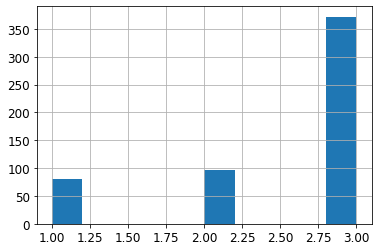

In [75]:
df[df['Survived'] == 0]['Pclass'].hist()